# Assignment 02: Solutions


In [49]:
import random
import time

---

## Grade-school multiplication

This code was given as part of the assignment.


In [50]:
def multiply(x: str, y: str) -> str:
    """Grade-school recursive split multiplication on decimal strings."""
    # BASE CASE
    # single digit multiplication
    if len(x) == 1 and len(y) == 1:
        return str(int(x) * int(y))

    # RECURSIVE PART
    # Shortcut to length
    n = max(len(x), len(y))
    # Zero-pad x to the left, for equal length
    if len(x) < n:
        x = "0" * (n - len(x)) + x
    # Zero-pad y to the right, for equal length
    if len(y) < n:
        y = "0" * (n - len(y)) + y
    # Split x,y in left and right halves
    half = n // 2
    a = x[:-half] if half > 0 else x
    b = x[-half:] if half > 0 else "0"
    c = y[:-half] if half > 0 else y
    d = y[-half:] if half > 0 else "0"
    # Compute partial products; multiply ac by 10^b
    ac = multiply(a, c) + ("0" * (2 * half))
    ad = multiply(a, d)
    bc = multiply(b, c)
    bd = multiply(b, d)
    # Multiply (ad+bc) by 10^{n/2}
    ad_plus_bc = str(int(ad) + int(bc)) + ("0" * half)
    # Done
    return str(int(ac) + int(ad_plus_bc) + int(bd))

---

## Karatsuba implementation

The code below contains some guard statements, just for illustrative purposes. The essential code begins near line 18 where the base cases are computed.


In [51]:
def karatsuba(x: str, y: str) -> str:
    """Karatsuba multiplication on non-negative decimal strings."""
    # Guard statements - a bit excessive but shown here for illustragiv
    # purposes.
    if x is None or y is None:
        raise ValueError("Inputs must be non-empty strings of digits.")
    x = x.strip()
    y = y.strip()
    if x == "" or y == "":
        raise ValueError("Inputs must be non-empty strings of digits.")
    if not x.isdigit() or not y.isdigit():
        raise ValueError("Inputs must contain only digits (non-negative integers).")

    # Just to be safe, make sure x, y are clean strings with int content
    x = str(int(x))
    y = str(int(y))

    # BASE CASES
    # Trivial and single-digit products
    if x == "0" or y == "0":
        return "0"
    if len(x) == 1 and len(y) == 1:
        return str(int(x) * int(y))

    # RECURSIVE PART
    # Shortcult to common length
    n = max(len(x), len(y))
    # Zero-pad x if needed
    if len(x) < n:
        x = "0" * (n - len(x)) + x
    # Zero-pad y if needed
    if len(y) < n:
        y = "0" * (n - len(y)) + y
    # Split inputs in left and right halves
    half = n // 2
    a = x[:-half] if half > 0 else x
    b = x[-half:] if half > 0 else "0"
    c = y[:-half] if half > 0 else y
    d = y[-half:] if half > 0 else "0"

    # Compute partial products
    z2 = karatsuba(a, c)
    z0 = karatsuba(b, d)
    z1_raw = karatsuba(str(int(a) + int(b)), str(int(c) + int(d)))
    z1 = str(int(z1_raw) - int(z2) - int(z0))
    # Multiply by powers of 10 by zero padding to the right
    z2_shifted = z2 + ("0" * (2 * half))
    z1_shifted = z1 + ("0" * half)
    # Done
    return str(int(z2_shifted) + int(z1_shifted) + int(z0))

---

## A simple simulation

The code below runs the two multiplication techniques and prints their results side-by-side. Time is measured in nanoseconds.


In [52]:
def simple_simulate() -> None:
    """Simple simulation method comparing grade school and Karatsuba
    multiplications side by side"""
    n = 2
    up_to = 2048

    # Range of digits to use in trial inputs
    low = 0
    high = 9

    print("   n\tmultiply (ns)\tkaratsuba (ns)")
    while n <= up_to:
        # Create random valued x and y with n digits
        x = "".join(str(random.randint(low, high)) for _ in range(n))
        y = "".join(str(random.randint(low, high)) for _ in range(n))

        # Time grade-school multiplication
        t0 = time.time_ns()
        _ = multiply(x, y)
        t1 = time.time_ns()
        t_mul = t1 - t0

        # Time Karatsuba multiplication
        t0 = time.time_ns()
        _ = karatsuba(x, y)
        t1 = time.time_ns()
        t_kar = t1 - t0

        # Print results
        print(f"{n:4d}\t{t_mul:14,d}\t{t_kar:14,d}")

        # Double the input size and try again
        n *= 2

---

## Advanced simulation

This code uses [`pandas`](https://pandas.pydata.org/) dataframes to hold the timing data, then produces plots visualizing the behavior of the two algorithms. This kind of simulation is beyond the scope of the assignment. It is published here for illustrative purposes.

_This simulation takes about 2-4 minutes to complete._


In [53]:
import statistics as stats  # for descriptive statistics
import pandas as pd  # for staging the plots
import matplotlib.pyplot as plt  # for plotting the results


def advanced_simulate(
    trials: int = 15, seed: int | None = 0
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Runs multiple timing trials for each n and returns:
      - df_trials: one row per (n, trial)
      - df_summary: aggregated stats per n (median/mean/stdev)
    """
    if trials <= 0:
        raise ValueError("trials must be a positive integer")

    if seed is not None:
        random.seed(seed)

    n = 2
    up_to = 2048 + 1  # +1 to ensure 2^11 is covered.

    # Range of digits to use
    low = 0
    high = 9

    # Temp holder for results
    trial_rows: list[dict[str, int]] = []

    print(f"Trials per n: {trials}")
    print("   n\tmul_med(ns)\tkar_med(ns)\tmul_mean(ns)\tkar_mean(ns)")
    while n <= up_to:
        mul_times: list[int] = []
        kar_times: list[int] = []
        # Repeat each experiment as many times as specified by trials
        # for smoother results
        for t in range(trials):
            # Create random inputs
            x = "".join(str(random.randint(low, high)) for _ in range(n))
            y = "".join(str(random.randint(low, high)) for _ in range(n))

            # Time grade-school multiplication
            t0 = time.time_ns()
            _ = multiply(x, y)
            t_mul = time.time_ns() - t0

            # Time Karatsuba multiplication
            t0 = time.time_ns()
            _ = karatsuba(x, y)
            t_kar = time.time_ns() - t0

            # Update the records for descriptive statistics
            mul_times.append(t_mul)
            kar_times.append(t_kar)

            # Update the records for the dataframe stage
            trial_rows.append(
                {
                    "n": n,
                    "trial": t,
                    "multiply_ns": t_mul,
                    "karatsuba_ns": t_kar,
                }
            )

        # Compute descriptive statistics
        mul_med = int(stats.median(mul_times))
        kar_med = int(stats.median(kar_times))
        mul_mean = int(stats.fmean(mul_times))
        kar_mean = int(stats.fmean(kar_times))

        # Print descriptive statistics
        print(
            f"{n:4d}\t{mul_med:15,d}\t{kar_med:15,d}\t{mul_mean:15,d}\t{kar_mean:15,d}"
        )
        # Double the size of the inputs
        n *= 2

    # Loop ended; move records to dataframe for easier handling
    df_trials = pd.DataFrame(trial_rows)

    # Summary stats per n
    grouped = df_trials.groupby("n", as_index=False).agg(
        multiply_median_ns=("multiply_ns", "median"),
        multiply_mean_ns=("multiply_ns", "mean"),
        multiply_std_ns=("multiply_ns", "std"),
        karatsuba_median_ns=("karatsuba_ns", "median"),
        karatsuba_mean_ns=("karatsuba_ns", "mean"),
        karatsuba_std_ns=("karatsuba_ns", "std"),
    )

    # Speedup metrics (using medians for robustness)
    grouped["speedup_mul_over_kar_median"] = (
        grouped["multiply_median_ns"] / grouped["karatsuba_median_ns"]
    )

    df_summary = grouped

    # ---- Plot 1: median timings (log y) ----
    plt.figure()
    plt.plot(
        df_summary["n"],
        df_summary["multiply_median_ns"],
        marker="o",
        label="grade-school median",
    )
    plt.plot(
        df_summary["n"],
        df_summary["karatsuba_median_ns"],
        marker="o",
        label="karatsuba median",
    )
    plt.yscale("log")
    plt.xlabel("n (digits)")
    plt.ylabel("time (ns) [log scale]")
    plt.title("Grade-school vs Karatsuba (median of trials)")
    plt.grid(True, which="both")
    plt.legend()

    # ---- Plot 2: optional variability band (median ± 1 std of trials) ----
    # Note: std is around the *mean* by definition; we still use it as a quick variability indicator.
    plt.figure()
    x = df_summary["n"]

    mul_center = df_summary["multiply_mean_ns"]
    mul_std = df_summary["multiply_std_ns"].fillna(0)

    kar_center = df_summary["karatsuba_mean_ns"]
    kar_std = df_summary["karatsuba_std_ns"].fillna(0)

    plt.plot(x, mul_center, marker="o", label="grade-school mean")
    plt.fill_between(x, mul_center - mul_std, mul_center + mul_std, alpha=0.2)

    plt.plot(x, kar_center, marker="o", label="karatsuba mean")
    plt.fill_between(x, kar_center - kar_std, kar_center + kar_std, alpha=0.2)

    plt.yscale("log")
    plt.xlabel("n (digits)")
    plt.ylabel("time (ns) [log scale]")
    plt.title("Grade-school vs Karatsuba (mean ± std across trials)")
    plt.grid(True, which="both")
    plt.legend()

    # ---- Plot 3: speedup ratio from medians (>1 means Karatsuba faster) ----
    plt.figure()
    plt.plot(df_summary["n"], df_summary["speedup_mul_over_kar_median"], marker="o")
    plt.axhline(1.0, linestyle="--")
    plt.xscale("log", base=2)
    plt.xlabel("n (digits) [log2 scale]")
    plt.ylabel("grade-school_median / karatsuba_median")
    plt.title("Relative performance (medians): above 1 => Karatsuba faster")
    plt.grid(True, which="both")

    plt.show()
    return df_trials, df_summary

Trials per n: 15
   n	mul_med(ns)	kar_med(ns)	mul_mean(ns)	kar_mean(ns)
   2	          7,204	         20,689	          7,856	         20,313
   4	         30,066	         66,855	         31,392	        172,721
   8	        122,689	        227,575	        256,828	        387,340
  16	        256,199	        364,271	        339,315	        576,982
  32	      1,818,925	      2,011,304	      1,685,470	      1,990,846
  64	      4,320,525	      3,165,588	      4,788,166	      3,891,296
 128	     16,178,849	      9,556,648	     16,047,027	     10,616,087
 256	     60,468,508	     31,915,912	     68,436,336	     35,260,849
 512	    246,722,409	     87,515,322	    256,060,935	    101,310,373
1024	    994,402,140	    258,501,185	    992,108,263	    269,633,628
2048	  4,019,727,196	    825,649,966	  4,030,943,741	    830,575,903


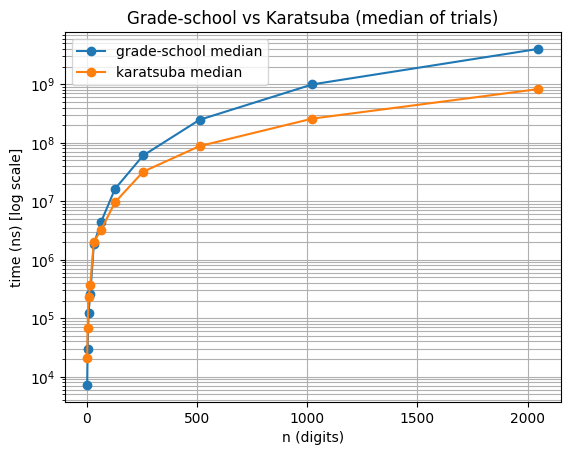

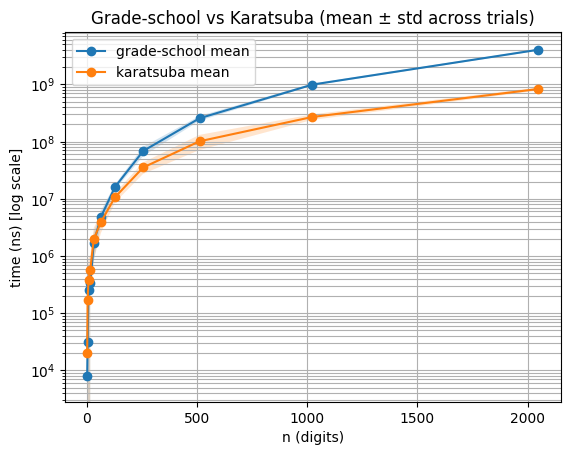

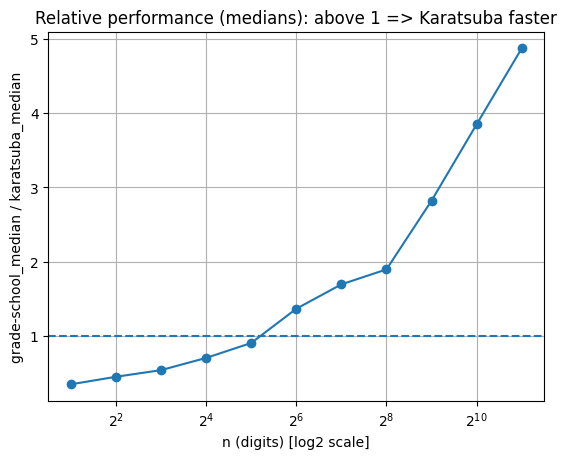


Summary:
   n  multiply_median_ns  multiply_mean_ns  multiply_std_ns  karatsuba_median_ns  karatsuba_mean_ns  karatsuba_std_ns  speedup_mul_over_kar_median
   2              7204.0      7.856067e+03     2.295296e+03              20689.0       2.031327e+04      5.283546e+03                     0.348204
   4             30066.0      3.139273e+04     4.772686e+03              66855.0       1.727210e+05      4.079481e+05                     0.449720
   8            122689.0      2.568283e+05     5.035157e+05             227575.0       3.873408e+05      5.302667e+05                     0.539115
  16            256199.0      3.393155e+05     1.273661e+05             364271.0       5.769823e+05      4.497475e+05                     0.703320
  32           1818925.0      1.685471e+06     8.627306e+05            2011304.0       1.990846e+06      1.133322e+06                     0.904351
  64           4320525.0      4.788167e+06     1.368574e+06            3165588.0       3.891297e+06      1.3

In [54]:
def main() -> None:
    df_trials, df_summary = advanced_simulate(trials=15, seed=0)

    print("\nSummary:")
    print(df_summary.to_string(index=False))


if __name__ == "__main__":
    main()

---

## Discussion

The results show that Karatsuba outperforms grade-school multiplication for mumbers with 64 or more digits. But we expect Karatsuba to be faster, in general, so why is it slower for numbers with 32 digits and less?

In theory, Karatsuba is in $\mathcal O(n^{1.58})$ and grade-school is in $\mathcal O(n^2)$. In practice, however, Karatsuba has more `str`/`int` operations than grade school. These operations slow down Karatsuba enough to give the slower grade-school technique the edge for smaller inputs. Karatsuba, however, takes the lead for seriously large inputs.
